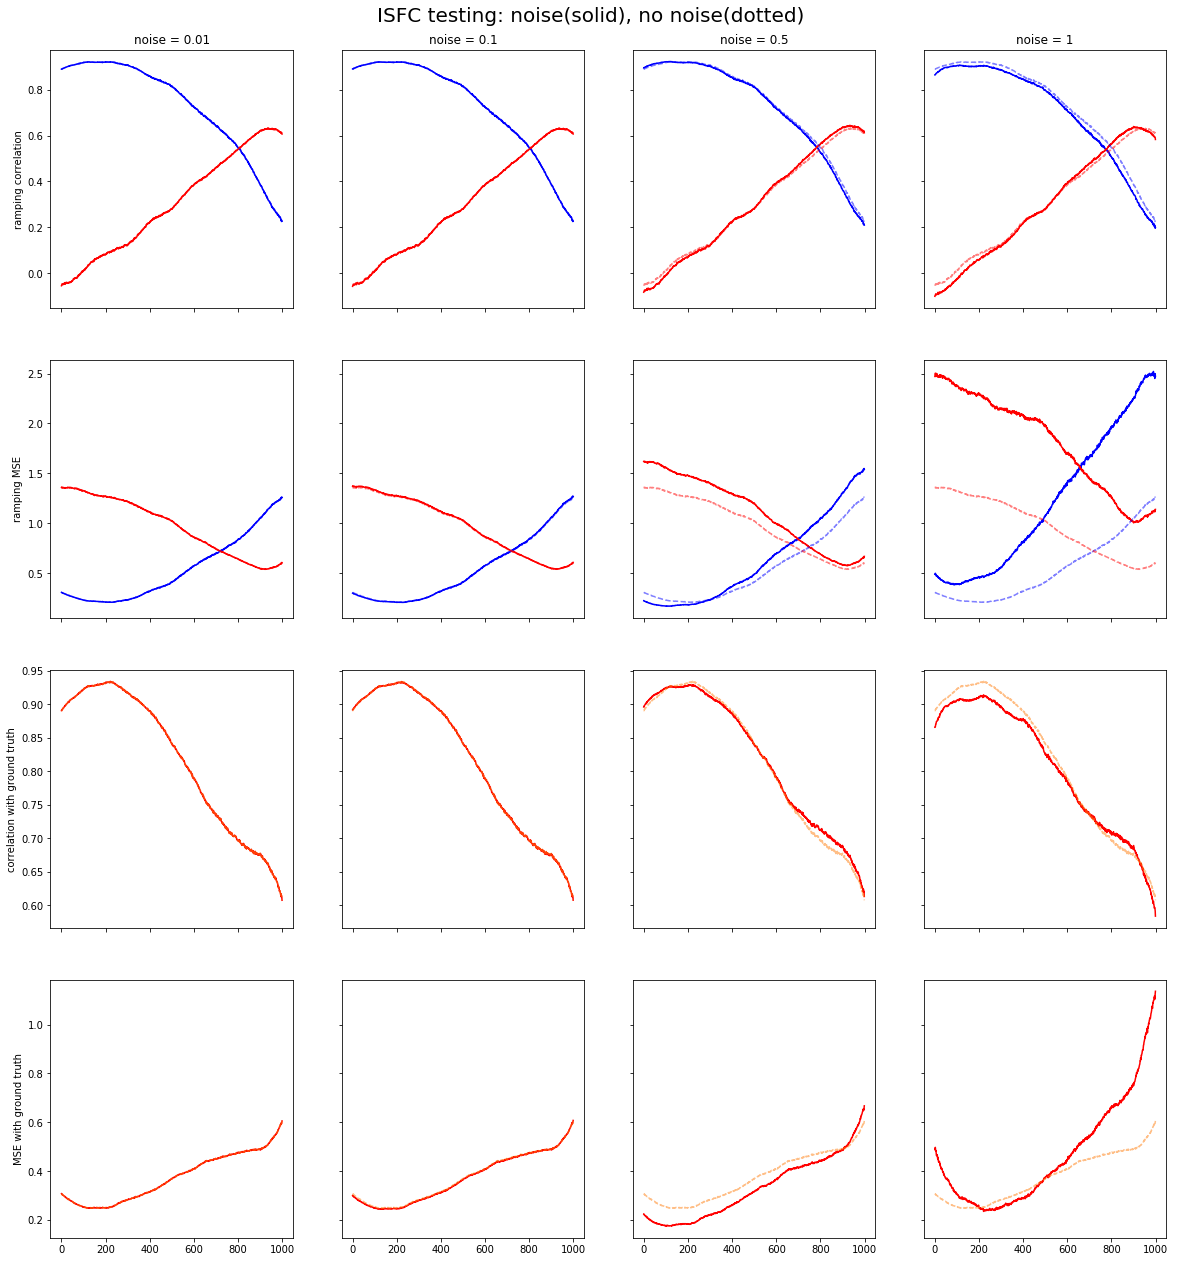

CPU times: user 24min 31s, sys: 15.6 s, total: 24min 47s
Wall time: 26min 11s


In [2]:
%%time
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import isfc, wcorr
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 1000
noise_level = [0,0.01,0.1,0.5,1]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
activation_num = 6
subject_num = 5
variance = 1000
activations = np.random.normal(0,1,[noise_num, subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (1000-i)*correlation1/float(time_len)+i*correlation2/float(time_len)
        correlations[i] = cov_temp/np.max(abs(cov_temp))
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level[i],[subject_num, activation_num, time_len])


timecorr_correlations1,timecorr_correlations2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])

timecorr_MSE1,timecorr_MSE2 = np.zeros([noise_num,time_len]),np.zeros([noise_num,time_len])

timecorr_correlations_single = np.zeros([noise_num,time_range])

timecorr_MSE_single = np.zeros([noise_num,time_range])
color = ['b','r']

timecorr_recovery = np.zeros([noise_num,time_len,(activation_num * (activation_num-1) / 2)])

for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for v in range(noise_num):
        timecorr_recovery[v] = isfc(activations[v],1000)
    for timepoint in range(time_len):
        for v in range(noise_num):
            otc1 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation1,checks=False))[0]
            timecorr_correlations1[v,timepoint] += 0.5 * (log(1+otc1) - log(1-otc1))
            otc2 = pearsonr(timecorr_recovery[v,timepoint], squareform(correlation2,checks=False))[0]
            timecorr_correlations2[v,timepoint] += 0.5 * (log(1+otc2) - log(1-otc2))
            
            sqr_mean = np.mean(np.square(timecorr_recovery[v,timepoint]))
            timecorr_MSE1[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint]-squareform(correlation1,checks=False)))/sqr_mean
            timecorr_MSE2[v,timepoint]+=np.mean(np.square(timecorr_recovery[v,timepoint]-squareform(correlation2,checks=False)))/sqr_mean
            
            otcs = pearsonr(timecorr_recovery[v, timepoint], squareform(correlations[timepoint],checks=False))[0]
            timecorr_correlations_single[v, timepoint]+= 0.5 * (log(1+otcs) - log(1-otcs))
            
            timecorr_MSE_single[v, timepoint]+=np.mean(np.square(timecorr_recovery[v, timepoint]-squareform(correlations[timepoint],checks=False)))/sqr_mean
        
        
timecorr_correlations1 /= repetitions
timecorr_correlations1 =  (np.exp(2*timecorr_correlations1) - 1)/(np.exp(2*timecorr_correlations1) + 1)

timecorr_correlations2 /= repetitions
timecorr_correlations2 =  (np.exp(2*timecorr_correlations2) - 1)/(np.exp(2*timecorr_correlations2) + 1)

timecorr_MSE1/= repetitions
timecorr_MSE2/= repetitions

timecorr_correlations_single /= repetitions
timecorr_correlations_single = (np.exp(2*timecorr_correlations_single) - 1)/(np.exp(2*timecorr_correlations_single) + 1) 

timecorr_MSE_single /= repetitions



f, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8),(ax9,ax10,ax11,ax12),(ax13,ax14,ax15,ax16)) = plt.subplots(4,4, sharex=True, sharey='row', figsize=(20,20))
a1,a2,a3,a4 = [ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8],[ax9,ax10,ax11,ax12],[ax13,ax14,ax15,ax16]
plt.subplots_adjust(top=0.95)
plt.suptitle("ISFC testing: noise(solid), no noise(dotted)",fontsize=20)
a1[0].set_title("noise = 0.01")
a1[1].set_title("noise = 0.1")
a1[2].set_title("noise = 0.5")
a1[3].set_title("noise = 1")
a1[0].set_ylabel("ramping correlation")
a2[0].set_ylabel("ramping MSE")
a3[0].set_ylabel("correlation with ground truth")
a4[0].set_ylabel("MSE with ground truth")
for v in range(1,noise_num): 
    a1[v-1].plot(range(time_len),timecorr_correlations1[v],c=color[0],linestyle='-',alpha=1.0)
    a1[v-1].plot(range(time_len),timecorr_correlations2[v],c=color[1],linestyle='-',alpha=1.0)

    a2[v-1].plot(range(time_len),timecorr_MSE1[v],c=color[0],linestyle='-',alpha=1.0)
    a2[v-1].plot(range(time_len),timecorr_MSE2[v],c=color[1],linestyle='-',alpha=1.0)

    a3[v-1].plot(range(time_len),timecorr_correlations_single[v],c='r',alpha=1,linestyle='-')
    a4[v-1].plot(range(time_len),timecorr_MSE_single[v],c='r',alpha=1,linestyle='-')
    
    a1[v-1].plot(range(time_len),timecorr_correlations1[0],c=color[0],linestyle='--',alpha=0.5)
    a1[v-1].plot(range(time_len),timecorr_correlations2[0],c=color[1],linestyle='--',alpha=0.5)

    a2[v-1].plot(range(time_len),timecorr_MSE1[0],c=color[0],linestyle='--',alpha=0.5)
    a2[v-1].plot(range(time_len),timecorr_MSE2[0],c=color[1],linestyle='--',alpha=0.5)

    a3[v-1].plot(range(time_len),timecorr_correlations_single[0],c='C1',linestyle='--',alpha=0.5)
    a4[v-1].plot(range(time_len),timecorr_MSE_single[0],c='C1',linestyle='--',alpha=0.5)
    
plt.show()